导入需要的库，检查CUDA是否可用，优先选择在GPU上训练，提高训练速度

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm


# 检查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


自定义的数据集类，数据的预处理以及标签和图像的对应都在这个类里完成

首先检测标签是否完整，对于不完整的标签直接剔除，正常的标签则用空格分隔后获取到性别、年龄、肤色等数据。浏览数据时发现有个别文件比其他文件大，这里选择用文件大小区分异常文件，大文件先处理成512x512的图像，然后再缩放成128x128的图像。

接下来检查是否有大面积全黑或全白的图片，计算完整标签对应的图像的平均灰度，过亮和过暗的图像都剔除。再处理过曝的图像：计算画面中心32x32区域内的平均灰度，过亮的图像则剔除。


In [4]:
# 自定义数据集类
class FaceDataset(Dataset):
    def __init__(self, data_files, raw_data_dir, transform=None, brightness_threshold=0.005, center_brightness_threshold=0.96):
        self.data_files = data_files
        self.raw_data_dir = raw_data_dir
        self.transform = transform
        self.brightness_threshold = brightness_threshold
        self.center_brightness_threshold = center_brightness_threshold
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []
        for data_file in self.data_files:
            with open(data_file, 'r') as f:
                for line_number, line in enumerate(f, start=1):
                    parts = line.strip().split()
                    if len(parts) < 5:
                        print(f"Skipping incomplete line {line_number}: {line}")
                        continue  # 跳过不完整或错误的数据行

                    try:
                        image_id = parts[0]
                        sex = parts[2].strip('()')
                        age = parts[4].strip('()')
                        race = parts[6].strip('()')
                        face = parts[8].strip('()')

                        #根据不同大小的文件选择不同的处理方式
                        image_path = os.path.join(self.raw_data_dir, image_id)
                        file_size_kb = os.path.getsize(image_path) / 1024

                        if file_size_kb < 20:
                            with open(image_path, 'rb') as f:
                                img = Image.fromarray(np.reshape(np.frombuffer(f.read(), dtype=np.uint8), (128, 128)))
                        else:
                            with open(image_path, 'rb') as f:
                                img = Image.fromarray(np.reshape(np.frombuffer(f.read(), dtype=np.uint8), (512, 512)))
                                img = img.resize((128, 128))
                        # 检查图片是否接近全黑或全白
                        img_array = np.array(img).astype(float)
                        avg_brightness = np.mean(img_array)
                        if avg_brightness < 255 * self.brightness_threshold or avg_brightness > 255 * (1 - self.brightness_threshold):
                            print(f"Skipping image {image_id} due to low or high overall brightness.")
                            continue  # 跳过过于暗或亮的图片

                        # 检查图片中心区域是否过亮
                        center_region = img_array[48:80, 48:80]  # 中心32x32区域
                        center_avg_brightness = np.mean(center_region)
                        if center_avg_brightness > 255 * self.center_brightness_threshold:
                            print(f"Skipping image {image_id} due to high brightness in the center region.")
                            continue  # 跳过中心区域过亮的图片

                        samples.append((image_id, sex, age, race, face))
                    except IndexError as e:
                        print(f"Skipping malformed line {line_number} due to error: {e}\nLine content: {line}")
                    except Exception as e:
                        print(f"Failed to process image {image_id}: {e}")

        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_id, sex, age, race, face = self.samples[idx]
        image_path = os.path.join(self.raw_data_dir, image_id)

        file_size_kb = os.path.getsize(image_path) / 1024

        if file_size_kb < 20:
            with open(image_path, 'rb') as f:
                img = Image.fromarray(np.reshape(np.frombuffer(f.read(), dtype=np.uint8), (128, 128)))
        else:
            with open(image_path, 'rb') as f:
                img = Image.fromarray(np.reshape(np.frombuffer(f.read(), dtype=np.uint8), (512, 512)))
                img = img.resize((128, 128))
        if self.transform:
            img = self.transform(img)

        # 将类别标签转换为整数
        sex_label = {'male': 0, 'female': 1}.get(sex, -1)
        age_label = {'child': 0, 'teen': 1, 'adult': 2, 'senior': 3}.get(age, -1)
        race_label = {'white': 0, 'yellow': 1, 'black': 2, 'hispanic': 0, 'asian': 1, 'other': 0}.get(race, -1)
        face_label = {'smiling': 0, 'serious': 1, 'funny': 2}.get(face, -1)

        labels = [sex_label, age_label, race_label, face_label]
        if any(label == -1 for label in labels):
            print(f"Invalid label in sample: {self.samples[idx]}")
            raise ValueError(f"Invalid label in sample: {self.samples[idx]}")

        return img, torch.tensor(labels, dtype=torch.long)


对数据集进行数据增强，包括旋转、颜色抖动的操作，增强数据集的代表性

In [5]:
# 数据变换，包括数据增强
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

浏览faceDR和faceDS后发现，原始的数据集中比较相似的数据会聚集在更近的范围内，直接用faceDR和faceDS中的一个作为训练集一个作为测试集使用的话，很容易出现测试集中出现训练集中没有的数据的情况。这里选择将faceDR和faceDS合并，随机打乱后再按照7:3的比例分为训练集和测试集的方法，尽量使训练集能覆盖到更多种类的数据

In [6]:

# 加载数据集
dataset = FaceDataset(data_files=['face/faceDR', 'face/faceDS'], raw_data_dir='face/rawdata', transform=train_transform)

# 打乱数据集并划分训练集和测试集
total_size = len(dataset)
train_size = int(0.7 * total_size)
test_size = total_size - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size],
                                           generator=torch.Generator().manual_seed(1523))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Skipping incomplete line 6:  1228 (_missing descriptor)

Skipping incomplete line 10:  1232 (_missing descriptor)

Skipping incomplete line 586:  1808 (_missing descriptor)

Skipping image 2099 due to low or high overall brightness.
Skipping image 2100 due to low or high overall brightness.
Skipping image 2101 due to low or high overall brightness.
Skipping image 2102 due to low or high overall brightness.
Skipping image 2103 due to low or high overall brightness.
Skipping image 2104 due to low or high overall brightness.
Skipping image 2105 due to low or high overall brightness.
Skipping image 2106 due to low or high overall brightness.
Skipping image 3283 due to low or high overall brightness.
Skipping image 3860 due to low or high overall brightness.
Skipping image 3861 due to low or high overall brightness.
Skipping image 3862 due to low or high overall brightness.
Skipping image 3883 due to low or high overall brightness.
Skipping incomplete line 834:  4056 (_missing descriptor)



初始化方法 (__init__):
conv1: 第一个卷积层，输入通道数为1（假设输入图像是灰度图像），输出通道数为32，卷积核大小为3x3，步幅为1，填充为1。
relu: ReLU激活函数，用于引入非线性。
pool: 最大池化层，池化窗口大小为2x2，步幅为2，无填充。
conv2: 第二个卷积层，输入通道数为32，输出通道数为64，卷积核大小为3x3，步幅为1，填充为1。
fc1: 全连接层，输入特征维度为643232（假设经过两次池化后图像尺寸变为32x32），输出特征维度为256。
fc2, fc3, fc4, fc5: 四个全连接层，分别对应性别、年龄、种族和表情的分类任务。每个全连接层的输出维度分别为2、4、3和3。
前向传播方法 (forward):
输入图像通过第一个卷积层、ReLU激活函数和最大池化层。
再通过第二个卷积层、ReLU激活函数和最大池化层。
将处理后的特征展平成一维向量。
通过第一个全连接层并再次应用ReLU激活函数。
分别通过四个全连接层得到性别、年龄、种族和表情的预测结果

In [7]:
# 定义卷积神经网络模型
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 256)
        self.fc2 = nn.Linear(256, 2)  # 性别
        self.fc3 = nn.Linear(256, 4)  # 年龄
        self.fc4 = nn.Linear(256, 3)  # 种族
        self.fc5 = nn.Linear(256, 3)  # 表情

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = self.relu(self.fc1(x))
        sex_output = self.fc2(x)
        age_output = self.fc3(x)
        race_output = self.fc4(x)
        face_output = self.fc5(x)
        return sex_output, age_output, race_output, face_output

model = SimpleCNN().to(device):
创建一个 SimpleCNN 实例，并将其移动到指定的设备（CPU或GPU）上。
criterion = nn.CrossEntropyLoss().to(device):
使用交叉熵损失函数作为损失函数，并将其移动到指定的设备上。交叉熵损失函数适用于多分类问题。
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.8):
使用随机梯度下降（SGD）优化器来更新模型参数。学习率为0.005，动量为0.8。动量有助于加速收敛并减少震荡。

  2%|▏         | 1/60 [00:02<02:32,  2.59s/it]

Epoch [1/60], Loss: 2.7038


  3%|▎         | 2/60 [00:04<02:16,  2.35s/it]

Epoch [2/60], Loss: 2.5495


  5%|▌         | 3/60 [00:06<02:08,  2.25s/it]

Epoch [3/60], Loss: 2.4092


  7%|▋         | 4/60 [00:09<02:04,  2.22s/it]

Epoch [4/60], Loss: 2.2495


  8%|▊         | 5/60 [00:11<02:02,  2.23s/it]

Epoch [5/60], Loss: 2.1499


 10%|█         | 6/60 [00:13<01:59,  2.21s/it]

Epoch [6/60], Loss: 2.0638


 12%|█▏        | 7/60 [00:15<01:55,  2.18s/it]

Epoch [7/60], Loss: 1.9752


 13%|█▎        | 8/60 [00:17<01:52,  2.17s/it]

Epoch [8/60], Loss: 1.8890


 15%|█▌        | 9/60 [00:19<01:49,  2.15s/it]

Epoch [9/60], Loss: 1.8814


 17%|█▋        | 10/60 [00:22<01:47,  2.15s/it]

Epoch [10/60], Loss: 1.7457


 18%|█▊        | 11/60 [00:24<01:44,  2.14s/it]

Epoch [11/60], Loss: 1.6882


 20%|██        | 12/60 [00:26<01:42,  2.13s/it]

Epoch [12/60], Loss: 1.5917


 22%|██▏       | 13/60 [00:28<01:40,  2.14s/it]

Epoch [13/60], Loss: 1.5316


 23%|██▎       | 14/60 [00:30<01:37,  2.13s/it]

Epoch [14/60], Loss: 1.4258


 25%|██▌       | 15/60 [00:32<01:35,  2.12s/it]

Epoch [15/60], Loss: 1.3692


 27%|██▋       | 16/60 [00:34<01:33,  2.13s/it]

Epoch [16/60], Loss: 1.3447


 28%|██▊       | 17/60 [00:36<01:31,  2.13s/it]

Epoch [17/60], Loss: 1.2451


 30%|███       | 18/60 [00:39<01:29,  2.13s/it]

Epoch [18/60], Loss: 1.2042


 32%|███▏      | 19/60 [00:41<01:27,  2.13s/it]

Epoch [19/60], Loss: 1.1396


 33%|███▎      | 20/60 [00:43<01:25,  2.14s/it]

Epoch [20/60], Loss: 1.1001


 35%|███▌      | 21/60 [00:45<01:23,  2.14s/it]

Epoch [21/60], Loss: 1.0534


 37%|███▋      | 22/60 [00:47<01:21,  2.15s/it]

Epoch [22/60], Loss: 1.0095


 38%|███▊      | 23/60 [00:49<01:19,  2.15s/it]

Epoch [23/60], Loss: 0.9484


 40%|████      | 24/60 [00:51<01:17,  2.15s/it]

Epoch [24/60], Loss: 0.9018


 42%|████▏     | 25/60 [00:54<01:15,  2.15s/it]

Epoch [25/60], Loss: 0.8592


 43%|████▎     | 26/60 [00:56<01:13,  2.16s/it]

Epoch [26/60], Loss: 0.8372


 45%|████▌     | 27/60 [00:58<01:11,  2.15s/it]

Epoch [27/60], Loss: 0.8013


 47%|████▋     | 28/60 [01:00<01:08,  2.15s/it]

Epoch [28/60], Loss: 0.7493


 48%|████▊     | 29/60 [01:02<01:06,  2.15s/it]

Epoch [29/60], Loss: 0.7012


 50%|█████     | 30/60 [01:04<01:04,  2.15s/it]

Epoch [30/60], Loss: 0.6807


 52%|█████▏    | 31/60 [01:07<01:02,  2.15s/it]

Epoch [31/60], Loss: 0.6479


 53%|█████▎    | 32/60 [01:09<01:00,  2.15s/it]

Epoch [32/60], Loss: 0.5969


 55%|█████▌    | 33/60 [01:11<00:58,  2.15s/it]

Epoch [33/60], Loss: 0.5703


 57%|█████▋    | 34/60 [01:13<00:55,  2.15s/it]

Epoch [34/60], Loss: 0.5570


 58%|█████▊    | 35/60 [01:15<00:53,  2.14s/it]

Epoch [35/60], Loss: 0.5371


 60%|██████    | 36/60 [01:17<00:51,  2.14s/it]

Epoch [36/60], Loss: 0.4786


 62%|██████▏   | 37/60 [01:19<00:49,  2.13s/it]

Epoch [37/60], Loss: 0.4803


 63%|██████▎   | 38/60 [01:21<00:46,  2.13s/it]

Epoch [38/60], Loss: 0.4483


 65%|██████▌   | 39/60 [01:24<00:44,  2.13s/it]

Epoch [39/60], Loss: 0.4552


 67%|██████▋   | 40/60 [01:26<00:42,  2.13s/it]

Epoch [40/60], Loss: 0.4034


 68%|██████▊   | 41/60 [01:28<00:40,  2.13s/it]

Epoch [41/60], Loss: 0.3621


 70%|███████   | 42/60 [01:30<00:38,  2.12s/it]

Epoch [42/60], Loss: 0.3903


 72%|███████▏  | 43/60 [01:32<00:36,  2.13s/it]

Epoch [43/60], Loss: 0.3608


 73%|███████▎  | 44/60 [01:34<00:34,  2.13s/it]

Epoch [44/60], Loss: 0.3473


 75%|███████▌  | 45/60 [01:36<00:31,  2.12s/it]

Epoch [45/60], Loss: 0.3358


 77%|███████▋  | 46/60 [01:38<00:29,  2.12s/it]

Epoch [46/60], Loss: 0.3109


 78%|███████▊  | 47/60 [01:41<00:27,  2.13s/it]

Epoch [47/60], Loss: 0.2694


 80%|████████  | 48/60 [01:43<00:25,  2.13s/it]

Epoch [48/60], Loss: 0.2621


 82%|████████▏ | 49/60 [01:45<00:23,  2.13s/it]

Epoch [49/60], Loss: 0.2065


 83%|████████▎ | 50/60 [01:47<00:21,  2.13s/it]

Epoch [50/60], Loss: 0.2168


 85%|████████▌ | 51/60 [01:49<00:19,  2.12s/it]

Epoch [51/60], Loss: 0.2387


 87%|████████▋ | 52/60 [01:51<00:16,  2.12s/it]

Epoch [52/60], Loss: 0.2079


 88%|████████▊ | 53/60 [01:53<00:14,  2.12s/it]

Epoch [53/60], Loss: 0.2324


 90%|█████████ | 54/60 [01:55<00:12,  2.12s/it]

Epoch [54/60], Loss: 0.2328


 92%|█████████▏| 55/60 [01:58<00:10,  2.12s/it]

Epoch [55/60], Loss: 0.2166


 93%|█████████▎| 56/60 [02:00<00:08,  2.12s/it]

Epoch [56/60], Loss: 0.1928


 95%|█████████▌| 57/60 [02:02<00:06,  2.12s/it]

Epoch [57/60], Loss: 0.1690


 97%|█████████▋| 58/60 [02:04<00:04,  2.13s/it]

Epoch [58/60], Loss: 0.1808


 98%|█████████▊| 59/60 [02:06<00:02,  2.13s/it]

Epoch [59/60], Loss: 0.1604


100%|██████████| 60/60 [02:08<00:00,  2.15s/it]

Epoch [60/60], Loss: 0.1471


Accuracy of the model on the test images: 86.72%
Accuracy of the model on the test images for each category:
male Accuracy: 88.90%
female Accuracy: 84.21%
Accuracy of the model on the test images for each category:
child Accuracy: 67.39%
teen Accuracy: 35.78%
adult Accuracy: 95.19%
senior Accuracy: 61.22%
Accuracy of the model on the test images for each category:
white Accuracy: 98.70%
yellow Accuracy: 40.74%
black Accuracy: 84.81%
Accuracy of the model on the test images for each category:
smiling Accuracy: 83.88%
serious Accuracy: 73.82%
funny Accuracy: 12.00%


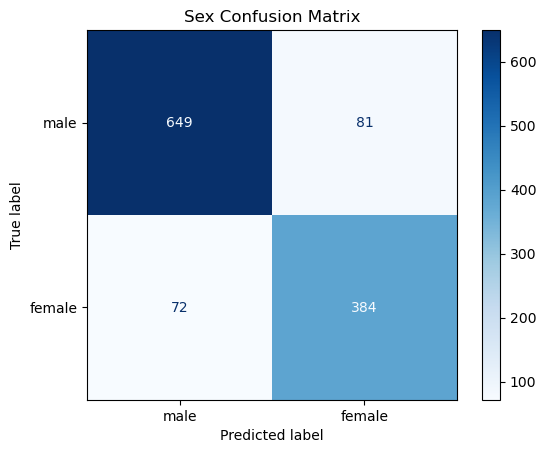

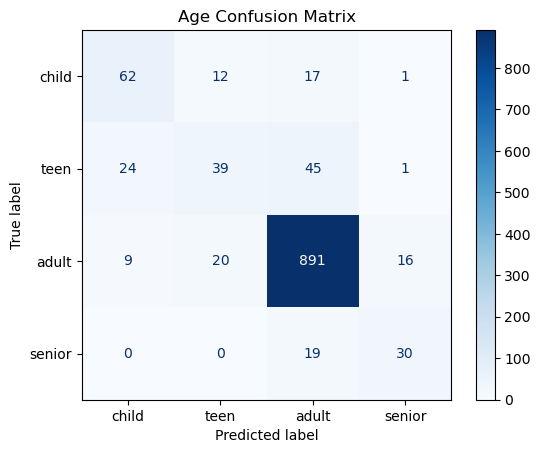

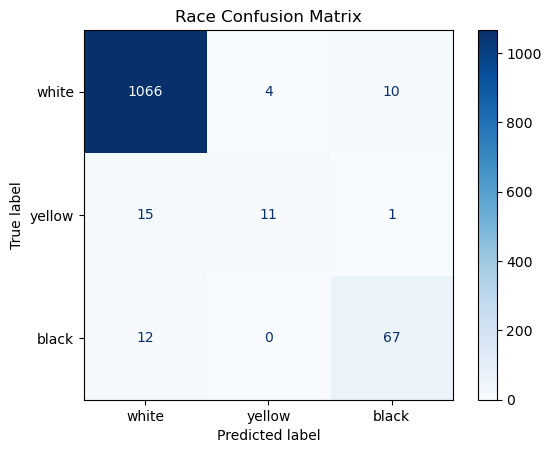

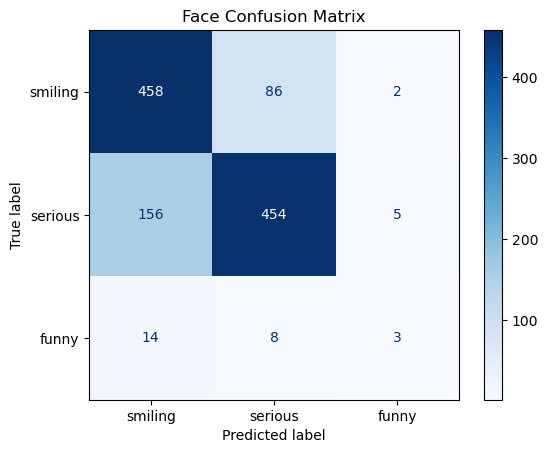

In [8]:
# 初始化模型、损失函数和优化器
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.8)
# 训练模型
num_epochs = 60
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        sex_outputs, age_outputs, race_outputs, face_outputs = model(images)
        loss = criterion(sex_outputs, labels[:, 0]) + \
               criterion(age_outputs, labels[:, 1]) + \
               criterion(race_outputs, labels[:, 2]) + \
               criterion(face_outputs, labels[:, 3])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# 评估模型
model.eval()
total = 0
correct = 0

# 存储所有真实标签和预测标签
true_labels = {'sex': [], 'age': [], 'race': [], 'face': []}
pred_labels = {'sex': [], 'age': [], 'race': [], 'face': []}

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        sex_outputs, age_outputs, race_outputs, face_outputs = model(images)
        _, predicted_sex = torch.max(sex_outputs, 1)
        _, predicted_age = torch.max(age_outputs, 1)
        _, predicted_race = torch.max(race_outputs, 1)
        _, predicted_face = torch.max(face_outputs, 1)

        true_labels['sex'].extend(labels[:, 0].cpu().numpy())
        pred_labels['sex'].extend(predicted_sex.cpu().numpy())
        true_labels['age'].extend(labels[:, 1].cpu().numpy())
        pred_labels['age'].extend(predicted_age.cpu().numpy())
        true_labels['race'].extend(labels[:, 2].cpu().numpy())
        pred_labels['race'].extend(predicted_race.cpu().numpy())
        true_labels['face'].extend(labels[:, 3].cpu().numpy())
        pred_labels['face'].extend(predicted_face.cpu().numpy())

        total += labels.size(0)

        correct += ((predicted_sex == labels[:, 0]).sum().item() +
                    (predicted_age == labels[:, 1]).sum().item() +
                    (predicted_race == labels[:, 2]).sum().item() +
                    (predicted_face == labels[:, 3]).sum().item()) / 4

print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

# 计算并打印各个类别的准确率
def calculate_accuracy(true_labels, pred_labels, num_classes, class_names):
    cm = confusion_matrix(true_labels, pred_labels, labels=list(range(num_classes)))
    row_sums = cm.sum(axis=1)
    accuracies = np.zeros(num_classes)
    for i in range(num_classes):
        if row_sums[i] > 0:
            accuracies[i] = cm[i, i] / row_sums[i]
    print(f'Accuracy of the model on the test images for each category:')
    for i, acc in enumerate(accuracies):
        print(f'{class_names[i]} Accuracy: {100 * acc:.2f}%')

calculate_accuracy(true_labels['sex'], pred_labels['sex'], 2, ['male', 'female'])
calculate_accuracy(true_labels['age'], pred_labels['age'], 4, ['child', 'teen', 'adult', 'senior'])
calculate_accuracy(true_labels['race'], pred_labels['race'], 3, ['white', 'yellow', 'black'])
calculate_accuracy(true_labels['face'], pred_labels['face'], 3, ['smiling', 'serious', 'funny'])

# 绘制混淆矩阵
def plot_confusion_matrix(true_labels, pred_labels, num_classes, class_names, title):
    cm = confusion_matrix(true_labels, pred_labels, labels=list(range(num_classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

plot_confusion_matrix(true_labels['sex'], pred_labels['sex'], 2, ['male', 'female'], 'Sex Confusion Matrix')
plot_confusion_matrix(true_labels['age'], pred_labels['age'], 4, ['child', 'teen', 'adult', 'senior'], 'Age Confusion Matrix')
plot_confusion_matrix(true_labels['race'], pred_labels['race'], 3, ['white', 'yellow', 'black'], 'Race Confusion Matrix')
plot_confusion_matrix(true_labels['face'], pred_labels['face'], 3, ['smiling', 'serious', 'funny'], 'Face Confusion Matrix')